In [1]:
import os

# Changes the notebook working directory on level up.
%cd ..

# Running main python script.
%run -i "src/main.py"

# Data set from main.py
data_set

/Users/Anne/Documents/UIS/DAT540/Project_Netflix/Project/dat540-netflix_catalogue


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,Unknown director,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,Unknown director,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,Unknown director,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,Unknown director,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,Unknown date_added,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,Unknown director,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,Unknown date_added,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,Unknown director,Unknown cast,Unknown country,Unknown date_added,2016,Unknown rating,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,Unknown director,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,Unknown date_added,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


In [2]:
from IPython.display import Image

# Predict genre from title and description
## In this section we are trying to predict genre from the two columns "title" and "description"
### The metedology is:

- Import libraries neeeded to make a suitable model and dataset for the model
- Clean up the information in the required columns in the dataframe
- Find the frequency of all the words used in title and description and remove the common stop words from the english language
- Set up a multi label binarizer which is a binary vector representing all genres
- Set up a logistic regression model to run the dataset 
- Use the one vs rest classifier to test each word against the binary vector of genres
- The goal is to link the most common words to a genre and be able to predict the genre from the description

## Why multilabel?

The target value we are testing is genre. Each movie can have several genres and we therefor need a model that can check the input towards several target values. Below is the common 1 vs 1 input to the model and target value represented on the left side. From our data we can have several genres and need a model as shown in the 1 vs multiple targets table.  

![title](multilabel.png)


In [3]:
# import packages needed for data analysis and visialization
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk

### Explore data set - genres
The Netflix catalogue has a total of 42 unique genres. The number of movies or TV shows in each genres vary a lot and ranges from 1927 movies in the "International Movies" category to only 10 entries in the "TV Shows" category. We see that a few genres are over represented in both the movie and TV show section and a lot of genres have a limited number of entries. The visualization section earlier in the notebook shows more of the distribution of the genres. 

Due to the relatively short data set and the large number of genres we see that we will have to modify the data set to get more accurate predictions. We ran the method in the end of this section on the full dataset (all genres and types) and will later compare these results to the final results, this to justify some of the choices that were made in the process of cleaning the dataset. 

In [4]:
# Lets check all the unique genres we have in the dataset and the count.
movie_genres = data_set['listed_in'].loc[data_set['type'] == 'Movie'].str.split(', ').explode().value_counts()
tvshow_genres = data_set['listed_in'].loc[data_set['type'] == 'TV Show'].str.split(', ').explode().value_counts()

print(movie_genres)
print(tvshow_genres)

International Movies        1927
Dramas                      1623
Comedies                    1113
Documentaries                668
Action & Adventure           597
Independent Movies           552
Thrillers                    392
Children & Family Movies     378
Romantic Movies              376
Stand-Up Comedy              281
Horror Movies                262
Music & Musicals             243
Sci-Fi & Fantasy             193
Sports Movies                157
Classic Movies                84
LGBTQ Movies                  60
Movies                        56
Cult Movies                   55
Faith & Spirituality          47
Anime Features                45
Name: listed_in, dtype: int64
International TV Shows          1001
TV Dramas                        599
TV Comedies                      436
Crime TV Shows                   363
Kids' TV                         328
Docuseries                       279
Romantic TV Shows                278
British TV Shows                 210
Reality TV    

## Cleaning the dataset

First we make a copy of the data set to start to prepare the data as input. It was decided to only use the Movies type for this exercise as this will still give us a large amount of data as there are 4265 movies in the data set. This will also eliminate 22 genres and leave us with 20 genres.

In [5]:
# create new data set with only type = Movie
new_set = data_set[data_set['type'] == 'Movie'].copy()

# Split genres into list
new_set['genre'] = new_set['listed_in'].apply(lambda x: x.split(', '))

#Total no. of movies:
print(f"Total no. of Movies in the data set: {new_set.shape[0]}")

Total no. of Movies in the data set: 4265


First we have to clean the data set to be able to input it in the functions later in this section. We will use the title and description columns to try to predict the genres. The method we use count the number of occurences of the words in the title and description and relate it to the genre of the movie. To be make sure that all equal words get counted we clean the data set by:
- making everything lower case
- remove all symbols and only keep letters from the English alphabet
- remove whitespaces

This is done using the clean_text() function on the columns "title" and "description". Then we added the title and description columns together as one text.

In [6]:
# function for text cleaning 
def clean_text(text):
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

# Clean each description and title using clean_text function
new_set['clean_desc'] = new_set['description'].apply(lambda x: clean_text(x))
new_set['clean_title'] = new_set['title'].apply(lambda x: clean_text(x))

# add title to description
new_set['title_description'] = new_set['clean_title'] + str(" ") + new_set['clean_desc']

From running the model with all genres, we saw that the categories with very few movies gave really poor results. It was therefore decided to remove the 8 least frequent genres (Anime to Sci-Fi & Fantasy in the list above). This was done by renaming them "Other", removing the lines where "Other" was the only genre and removing the rest of the "Other" category from the other movies. This left a data set that still has at least one genre per movie, but we have eliminated most of the genres that would have caused "noise" in the results. With this we end up with 12 unique genres.

In [7]:
# List of 8 genres with the least no. of movies
rare_genres = data_set[data_set.type=="Movie"].listed_in.str.split(', ').explode().value_counts().index[-8:]

# Rename the 8 rare genres above with "Other"
new_set['genre'] = new_set.genre.apply(lambda x: ["Other" if np.isin(y, rare_genres) else y for y in x])
# Remove "Other" from the data set
new_set = new_set[new_set.genre != "Other"]
new_set['genre'] = (new_set.genre.map(set)-{'Other'}).map(list)

## Find the frequency the words are apperaing in the data set
First we take a look at the data set and the most frequent words in the title and description of the dataset. We plot this to get an idea if these can be used to predict the genres. We see that the most frequent words are as expected short words used to connect sentences, such as "a", "the" and "to". These will be used in all categories and will not help to identify the genre of the movie.

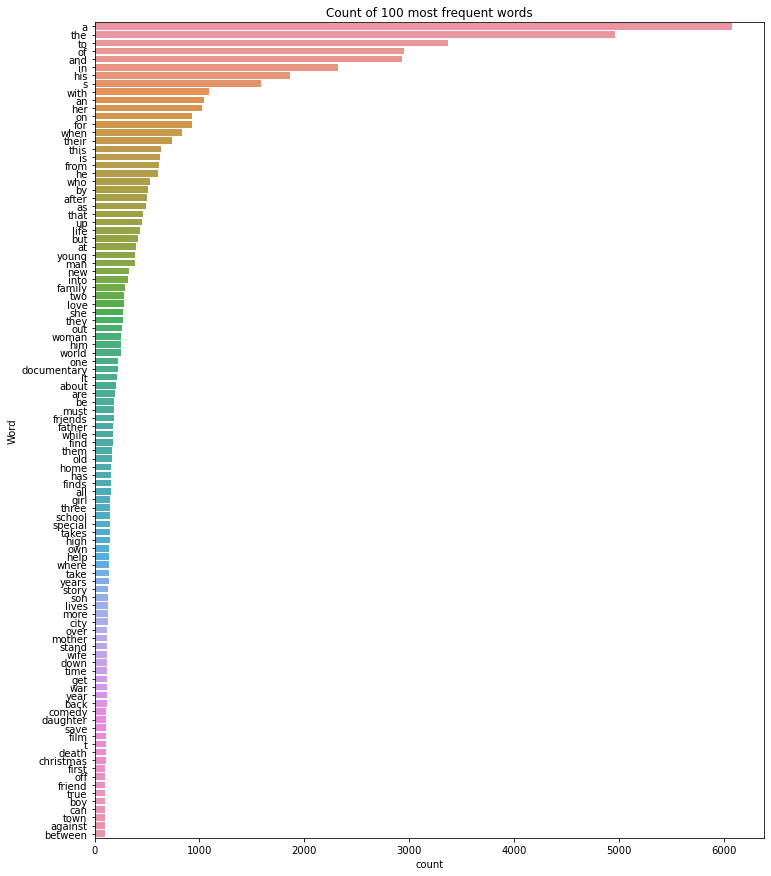

In [8]:
def freq_words(text, terms = 30): 
  # Create word list from all words in title and description in pandas series
  words = text.str.split(expand=True).stack()
  
  # selecting top n most frequent words in order
  d = words.value_counts().index[:terms]
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.countplot(y=words, order=d)
  ax.set(ylabel = 'Word') 
  ax.set_title(f"Count of {terms} most frequent words")
  plt.show()
  
# print 100 most frequent words 
freq_words(new_set['title_description'], 100)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/Anne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Remove all the stop words from the dataset

As mentioned above, we see that the most common words un the dataset are typically "a", "the", "to", etc. These common words will not give any value in predicting the genres. Stop words are the most common words in the English language, a list of these can be used to remove these words in the data set. A common way to remove stop words is to import the library stopwords from nltk.corpus. <br>
A good solution to remove stop words was found at. https://www.geeksforgeeks.org/removing-stop-words-nltk-python/


In [10]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

new_set['title_description'] = new_set['title_description'].apply(lambda x: remove_stopwords(x))

The new most frequent words after removing stopwords have been plotted below. We see that we now have words that could potentially represent cretain genres. 

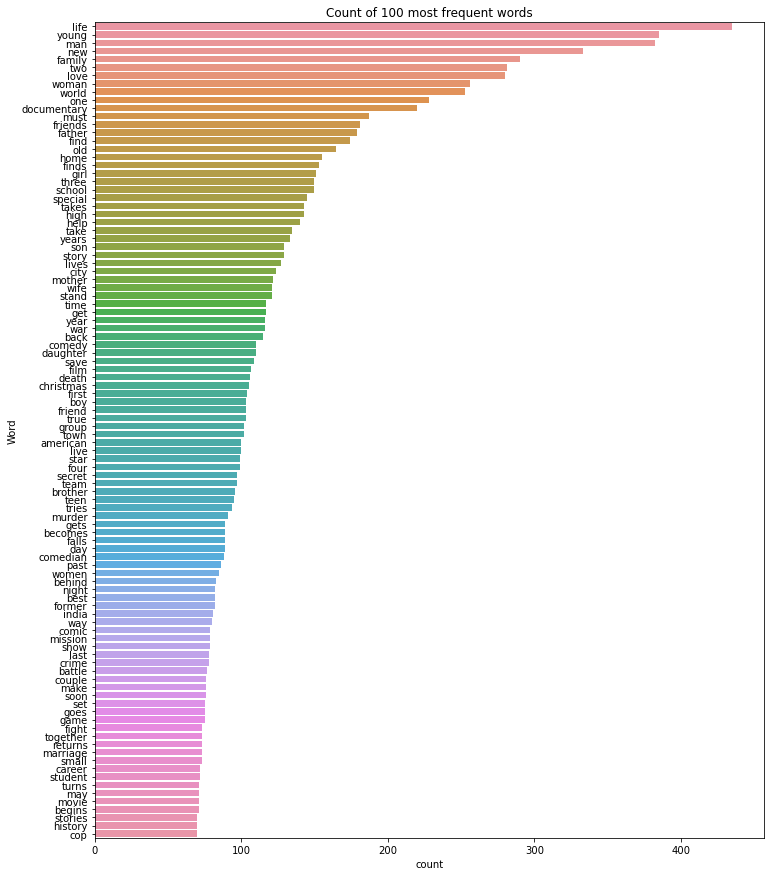

In [11]:
# Check most frequent words after removing stopwords
freq_words(new_set['title_description'], 100)

## Genre predictions

Since we have a multi label data set (one movie can have multiple genres), we need to transform the target variable (genres) into separate target variables.
We use the Binary Relevance approach to assign the genre to the unique target label.

The sklearn MultiLabelBinarizer allows us to encode multiple labels per instance saved in a class label. This transforms the target into an array of binary values where 1 and 0 at different locations in the arrays represents the genres with one target variable per unique genre. 


In [12]:
#Import MultiLabelBinarizer from sklean
from sklearn.preprocessing import MultiLabelBinarizer 

mlb = MultiLabelBinarizer()

# Fit the label sets and transform target variable
y = mlb.fit_transform(new_set['genre'])


We see that the multi label binarizer represents all genres as a binary array. The labels are stored in the classes_ and can be related to the array by transformation. 

By printing one row from the y where the genres are fitted we see that we get a binary vector with zeros and ones.
By printing the inverse_transform we can see which genres this binary vector represents.

We now have a representation of the target value as described in the introduction to predicting genre from description

In [13]:
# The binary classes:
print(f"Class labels: \n{mlb.classes_} \n")

# We see that the genres are represented as a binary vector with values 0 and 1
# A 1 represents that this row have the genre at this position on the label list.
print(y[3]) # Example
# By taking the inverse transferm we can see that what genre the bianry represents
print(mlb.inverse_transform(y)[3])

Class labels: 
['Action & Adventure' 'Children & Family Movies' 'Comedies'
 'Documentaries' 'Dramas' 'Horror Movies' 'Independent Movies'
 'International Movies' 'Music & Musicals' 'Romantic Movies'
 'Stand-Up Comedy' 'Thrillers'] 

[0 0 0 0 0 0 0 1 0 0 0 1]
('International Movies', 'Thrillers')


To relate the title and description to the genre, we use a method to count the number of words and their frequency and relate this to the genre. The method chosen is the sklean TF-IDF Vectorizer. TF-IDF stands for Term Frequency — Inverse Document Frequency and is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus. TfidVectorizer transforms text to feature vectors that can be used as input to estimator.

The data set used is relatively short, and as seen above, the 100th most frequent word after removing stopwords is only used about 70 times. It was therefore decided to initialize the TfidVectorizer with the 1000 most frequent words using max_features = 1000. To make sure we don@t have an over-representation of some words with a very high frequency, max_df was set to 0.8, so that words with frequency higher than 80% is filtered out. 

The data set is then split into train and validation sets for training and evaluating the model's performance. We have found that an 80-20 split where 80% of the data samples are in the train set and the rest are in the validation set is common. Setting of the random_state parameter ensures same results every time.

In [14]:
# Import TfidVectorizer and train_test_split from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialize TfidVectorizer with 1000 most frequent words
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=1000)

# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(new_set['title_description'], y, test_size=0.2, random_state=10)

# create TF-IDF features
# fit_transform(): Learn vocabulary and idf from training set, return document-term matrix
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain) 
xval_tfidf = tfidf_vectorizer.transform(xval)

## How to handle multilabel in a logistic regression model?

The logistic regression model will check input vs one target value and will not work directly on a multilabel target. OneVsRestClassifier is the most commonly used strategy for multiclass classification. The one vs rest will split the multi-label dataset into multiple binary classification problems. If we have the multi-label set (Action, Drama, Horror), then the one vs rest classifier will divide the problem into

- Binary classification problem 1: Action vs Drama, Horror
- Binary classification problem 2: Drama vs Action, Horror
- Binary classification problem 3: Horror vs Action, Drama

This way we can run a logistic regression model on a multilabel target value. We see that the number of calculations will be larger with the the one vs rest classifier. However, the dataset for the netflix catalouge is small enough that the runtime will not be very long. However this approach will be time consuming when there is very large data set. 

https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html?highlight=onevsrestclassifier&fbclid=IwAR3Hm-791LbLCwBVkIUdSFo3hUBiWWUdWQ4AyLYj89uEWSjMuKXR_52HKJY#sklearn.multiclass.OneVsRestClassifier

In [15]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

In [16]:
lr = LogisticRegression() # Set up the logistic regression model
clf = OneVsRestClassifier(lr)   # make a one vs rest classifier of the logistic regression model

In [17]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [18]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

## Evaluate results

First we check a randomly picked prediction to check if we get results. We see that this title gives 2 predictions. 

In [19]:
#Check prediciton 
print(y_pred[3])

# Inverse transform to get genres:
print(mlb.inverse_transform(y_pred)[3])


[0 0 0 0 1 0 0 1 0 0 0 0]
('Dramas', 'International Movies')


To evalueate the results we check the confusion matrix for all the genres. This will tell us wheter the prediction is a true positive, true negative, false positive or false negative as seen in the matrix below. 

![confusion_matrix](confusion_matrix.png)

True positive and true negatives are the observations that are correctly predicted and therefore desirable. 

The True Positive (TP) are the correctly predicted positive values which means that the value of actual label and predicted label is yes. E.g. Predicted Drama, actual genre is drama. 

The True Negative (TN) are the correctly predicted negative values which means that the value of actual label and predicted label is no. E.g. Predicted not Drama, actual genre is not Drama. 

The False positives (FP) occurs when actual label is no and predicted label is yes. E.g. Predicted Drama, actual class not Drama.

The False negatives (FN) occurs when actual label is yes and prediced label is no. E.g. predicted not Drama, actual label is Drama. 

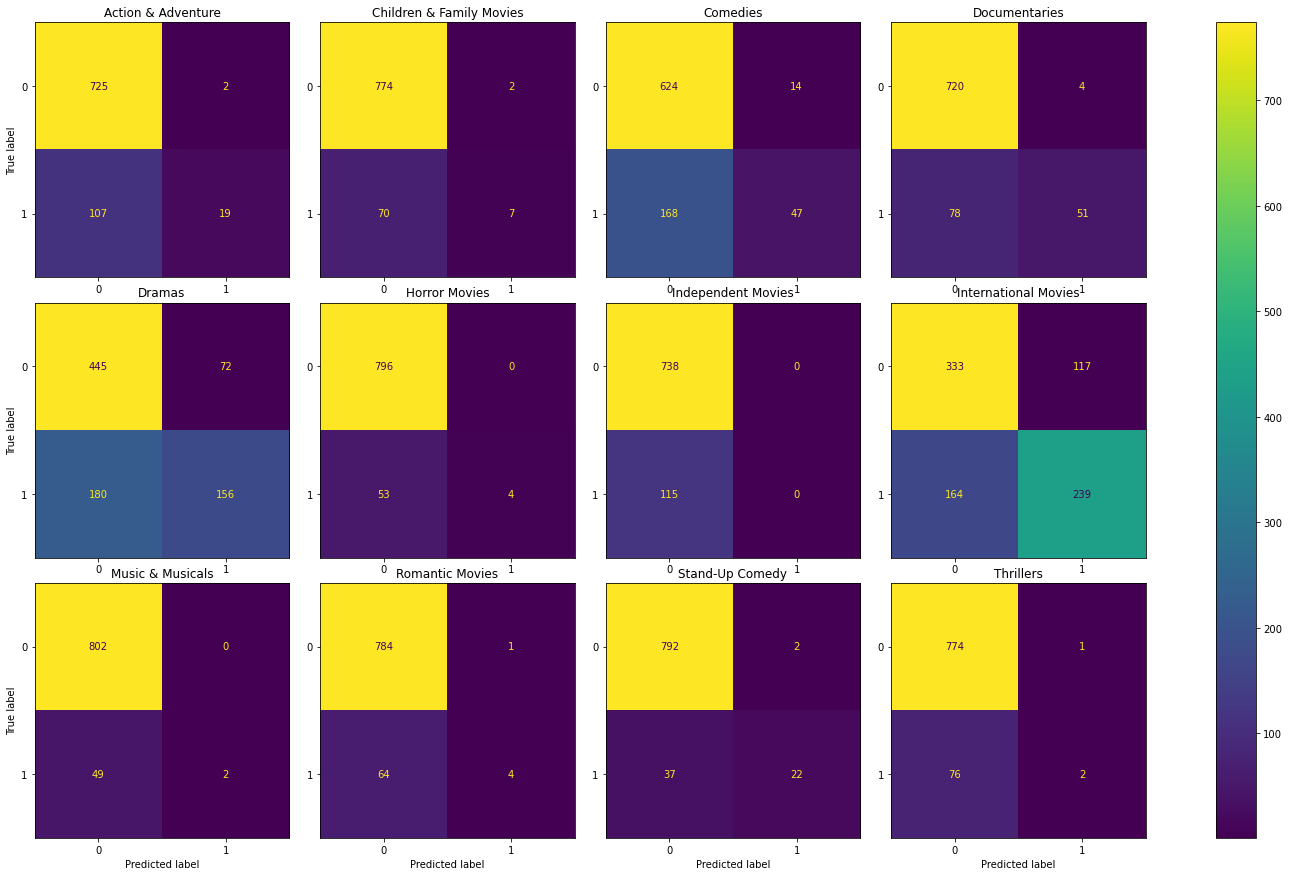

In [20]:
# Make a plot of the confusion matrix for each genre
f, axes = plt.subplots(3, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(12):
    disp = ConfusionMatrixDisplay(confusion_matrix(yval[:, i],
                                                   y_pred[:, i]),
                                  display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'{mlb.classes_[i]}')
    if i<8:
        disp.ax_.set_xlabel('')
    if i%4!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

The results show that all predictions have a high True Negative score which is to be expected since there are several genres and some genres have few movies. For the categories with the most movies, such as Dramas and International Movies, the True Positives are higher, but this is quite low for some genres. The false Negative (FN) score on most is higher than we would have liked. 

We then check the classification report which gives the precision score, recall score and f1 score for each genre and combined below. 

The precision score gives the ratio of predicted positive observations to total predicted positive observations: <br>
Precision = TP/(TP+FP)

The Recall (Sensitivity) is the ratio of correctly predicted positive observations to all the observations in class = yes: <br>
Recall = TP/(TP+FN)

F1 score is the weighted average of Precision and Recall. Therefore this score takes both false positives and false negatives into account: <br> 
F1 Score = 2*(Recall * Precision)/(Recall + Precision)

Source: https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

In [21]:
# Check classification report with precision score, recall score and f1 score.
report = classification_report(yval, y_pred, output_dict=True)
class_df = pd.DataFrame(report).transpose()
gen_list = np.append(mlb.classes_, ["","","",""])
class_df['genre'] = gen_list
class_df

,precision,recall,f1-score,support,genre
0,0.904762,0.150794,0.258503,126.0,Action & Adventure
1,0.777778,0.090909,0.162791,77.0,Children & Family Movies
2,0.770492,0.218605,0.340580,215.0,Comedies
3,0.927273,0.395349,0.554348,129.0,Documentaries
4,0.684211,0.464286,0.553191,336.0,Dramas
5,1.000000,0.070175,0.131148,57.0,Horror Movies
6,0.000000,0.000000,0.000000,115.0,Independent Movies
7,0.671348,0.593052,0.629776,403.0,International Movies
8,1.000000,0.039216,0.075472,51.0,Music & Musicals
9,0.800000,0.058824,0.109589,68.0,Romantic Movies


We see that the precision score is generally high for most genres, except Independent Movies, giving a micro average of 0.72. This is generally quite good. The recall score is quite low for some genres due to the large amount of false negatives for some of the genres. The micro average for recall is 0.32. This gives an f1 score of 0.44.

## Predictions

To show how the model predicts the genres, we pick 50 random movies in the data set and check them in the model and print the results. 

We see that the model predicts the large genres such as International Movies and Dramas quite well and also smaller genres such as Stand-Up Comedy, probably due to the prevalence of words like comedian and stand-up in these descriptions. The model is though hesitant to give predictions to several movies, which leads to a several false negatives and a low recall score. 

In [22]:
# Function to predict genre using method above for a given movie
def predict_tags(q):
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return mlb.inverse_transform(q_pred)

In [23]:
# Print movie title, predicted genre and actial genre for 50 random movies
for i in range(50): 
  k = xval.sample(1).index[0] 
  print("Movie: ", new_set['title'][k], "\nPredicted genre: ", predict_tags(xval[k])), print("Actual genre: ",new_set['genre'][k], "\n")


Movie:  The Desert Bride 
Predicted genre:  [()]
Actual genre:  ['International Movies', 'Dramas'] 

Movie:  An Hour and a Half 
Predicted genre:  [('Dramas', 'International Movies')]
Actual genre:  ['International Movies', 'Dramas'] 

Movie:  Secret in Their Eyes 
Predicted genre:  [('Dramas',)]
Actual genre:  ['Thrillers', 'Dramas'] 

Movie:  Moonlight 
Predicted genre:  [('Dramas',)]
Actual genre:  ['Independent Movies', 'Dramas'] 

Movie:  Underdogs 
Predicted genre:  [('Documentaries',)]
Actual genre:  ['Documentaries', 'International Movies', 'Music & Musicals'] 

Movie:  The Ridiculous 6 
Predicted genre:  [()]
Actual genre:  ['Action & Adventure', 'Comedies'] 

Movie:  1000 Rupee Note 
Predicted genre:  [('Dramas', 'International Movies')]
Actual genre:  ['International Movies', 'Dramas'] 

Movie:  The Little Prince 
Predicted genre:  [()]
Actual genre:  ['Children & Family Movies'] 

Movie:  The Eyes of My Mother 
Predicted genre:  [('Dramas', 'International Movies')]
Actual g

## Evaluation of Model and Data Set

The cleaning of the data set was important to get an OK precision score. 

At first we tried to use the model to predict the genre with the complete data set and using the description only. The classification report for this is shown below. We see that this gave a low or 0 score for precision for a lot of categories. We could see that it would not be possible to get good predictions without removing some of the genres. Most of the TV genres gave a lower score and it was therefore decided to try to only use movies. In addition we added the title to the prediction data to increase the number of words that could be used.

![pre_data_clean](pre_genre_clean.png)

The model can still not predict all genres. To get a model that can predict everything we either need a larger dataset to get more words to relate to each genre, or perhaps use methods like word embedding where someone has made a database of words that has already been trained such that words like house and home are given related meaning. We could also try to combine more of the genres that are similar. 

The model is best at predicting genres where there are many movies, and has problems with the less frequent genres. 